# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

## Task:
- Quadratic function
- Normal noise
- Anomalies
- Anomalies detection
- LSM
- Kalman filter (matrix, 1 order)

## Imports

In [451]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Config

In [452]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

## Parameters

In [453]:
PARAM_selection_size = 100
PARAM_anomaly_size = int(0.1 * PARAM_selection_size)
PARAM_widnow_size = int(0.2 * PARAM_selection_size)

PARAM_normal_mean = 0
PARAM_normal_std = 2

PARAM_max_test_pow = 11

PARAM_alpha = 0.2
PARAM_beta = 0.2

## Functions

In [454]:
def describe_all(_data, trend_column):
    """Prints stats of all data in dictionary"""
    # create df
    df = pd.DataFrame(_data)
    # remove trend from other data
    trend_data = df[trend_column].copy()
    for column in df.columns:
            df[column] = df[column] - trend_data
    # find stats and calc var
    stats = df.describe()
    stats.loc["var"] = stats.loc["std"] ** 2
    return stats

In [455]:
def lsm_create_f(size, pol_pow):
    """
    Creating F matrix:
    1, x, x^2, ..., x^PARAM_max_pow
    """
    
    F = np.ones((size, pol_pow + 1))
    for i in range(1, pol_pow + 1):
        # pow
        F[:, i] = np.power(np.arange(0, size), i)
    return F


def lsm_coef(y, F):
    """
    Returns matrix of coef. C.
    """

    # 1-d array to row vector
    Y = y.reshape(-1, 1)
    # calc
    FT = F.T
    FF = np.dot(FT, F)
    FFI = np.linalg.inv(FF)
    FFIFT = np.dot(FFI, FT)
    # return coef
    return np.dot(FFIFT, Y)


def lsm(y, pol_pow):
    """
    LSM
    y - 1d array of values,
    pol_pow - polynomial power of model
    """

    F = lsm_create_f(len(y), pol_pow)
    C = lsm_coef(y, F)
    # returning array, reshaped from row vector to 1d
    return np.dot(F, C).reshape(-1)

In [456]:
def find_anomalies(data, sliding_window_size, lsm_pow, std3):
    """
    Returns indexes of anomalies.
    """
    anomaly_index = []
    
    for i in range(0, len(data) - sliding_window_size):
        # new window
        window = data[i:(sliding_window_size + i)]
        # finding C matrix for current window
        coef = lsm_coef(window, lsm_create_f(sliding_window_size, lsm_pow))
        # prediction of next value
        y_hat = np.dot(lsm_create_f(sliding_window_size + 1, lsm_pow), coef).reshape(-1)[-1]
        # if difference between predicted and real value is more than 3*std => anomaly
        if abs(data[sliding_window_size + i] - y_hat) > std3:
            anomaly_index.append(sliding_window_size + i)
    return anomaly_index

In [457]:
def fix_anomalies(data, anomaly_index):
    # copy
    data_fix = data.copy()
    # for every anomaly in data
    for i in anomaly_index:
        vals = []
        # append prev value
        vals.append(data_fix[i-1])
        # append value-anomaly
        vals.append(data_fix[i])
        # append next values (presuming they are also value-anomalies) until normal value is found
        ends_with_normal_value = False
        for j in range(i + 1, len(data_fix)):
            vals.append(data_fix[j])
            if j not in anomaly_index:
                ends_with_normal_value = True
                break
        # if ends with normal value - fit a line and restore values
        if ends_with_normal_value:
            step = (vals[-1] - vals[0]) / (len(vals) - 1)
        # else fit a line through 2 previous normal values
        else:
            step = data_fix[i-1] - data_fix[i-2]

        # restore values
        # but if vals ends with normal value - cast True to 1 and dont update the last value, that is normal
        # else casting False to int will result in 0, and the last value, that is also anomal will be updated
        for j in range(len(vals) - 1 - int(ends_with_normal_value)):
            data_fix[i+j] = vals[0] + step * (j + 1)
    return data_fix

## Errors and anomalies

In [458]:
# normal error
_normal = np.random.normal(PARAM_normal_mean, PARAM_normal_std, PARAM_selection_size)

# adding anomalies at indexes, drawn from uniform distribution
# starting from PARAM_widnows_size to get std of normal error without anomalies
# (instead of manually removing anomalies from first window)
_normal_anomalies = _normal.copy()
_anomaly_index = np.unique(np.random.randint(PARAM_widnow_size, PARAM_selection_size, PARAM_anomaly_size))
for i in _anomaly_index:
    while abs(_normal_anomalies[i]) < _normal.std() * 3:
        _normal_anomalies[i] *= 2

## Artificial anomalies: last value and two consecutive values to test anomaly detection/restoration algorithms
_anomaly_test_index = [-1, int((PARAM_widnow_size*1.6)), int((PARAM_widnow_size*1.6) + 1)]
for i in _anomaly_test_index:
    while abs(_normal_anomalies[i]) < _normal.std() * 3:
            _normal_anomalies[i] *= 2
print("Indexes of anomalies:", _anomaly_index, "\n")
print("Indexes of test anomalies", _anomaly_test_index)

Indexes of anomalies: [36 52 57 64 65 66 76 91 93] 

Indexes of test anomalies [-1, 32, 33]


## Data

In [459]:
data = {}

# quadratic, + noise, + anomalies
data["quadratic"] = np.square(np.linspace(0, 10, PARAM_selection_size))
data["quadratic_normal"] = data["quadratic"].copy() + _normal
data["quadratic_normal_anomalies"] = data["quadratic"].copy() + _normal_anomalies

describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies
count,100.000,100.000,100.000
mean,0.000,0.219,0.060
std,0.000,2.000,3.315
min,0.000,-4.974,-9.527
25%,0.000,-1.092,-1.335
50%,0.000,0.244,0.303
75%,0.000,1.595,1.768
max,0.000,5.263,7.545
var,0.000,4.000,10.991


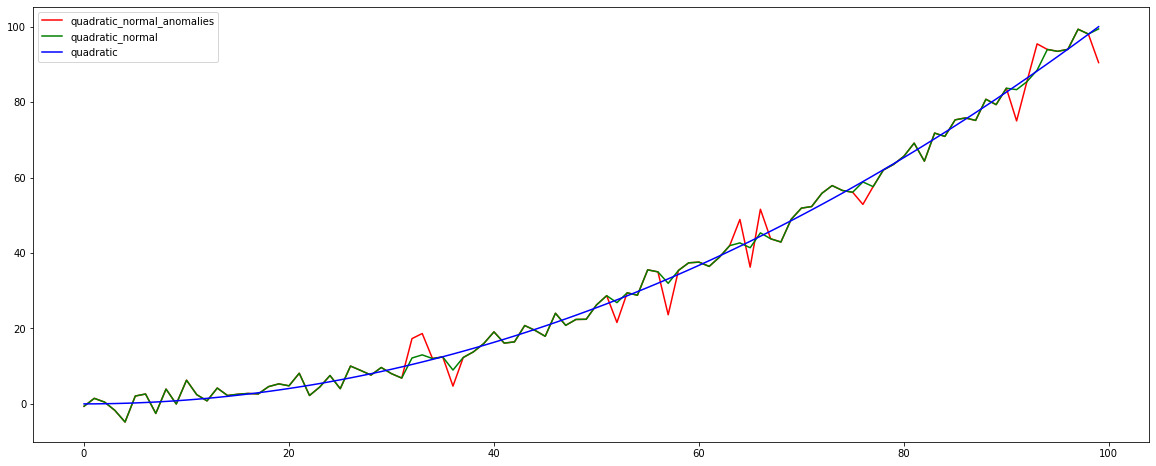

In [460]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="red")
plt.plot(data["quadratic_normal"], label="quadratic_normal", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.legend()
plt.show()

## Detecting Anomalies with Sliding Window

In [461]:
data["quadratic_normal_anomalies_fix"] = data["quadratic_normal_anomalies"].copy()
window = data["quadratic_normal_anomalies_fix"][:PARAM_widnow_size]

std3 = 3 * abs((window - lsm(window, PARAM_best_pow)).std())
print("Estimated 3*std:", std3)

Estimated 3*std: 6.354731214763737


In [462]:
# save indexes and values of anomalies
anomaly_index = find_anomalies(data["quadratic_normal_anomalies"], PARAM_widnow_size, 1, std3)
anomaly_value = data["quadratic_normal_anomalies"][anomaly_index]
print(anomaly_index)

[32, 33, 36, 57, 64, 65, 66, 76, 91, 93, 99]


## Detected anomalies

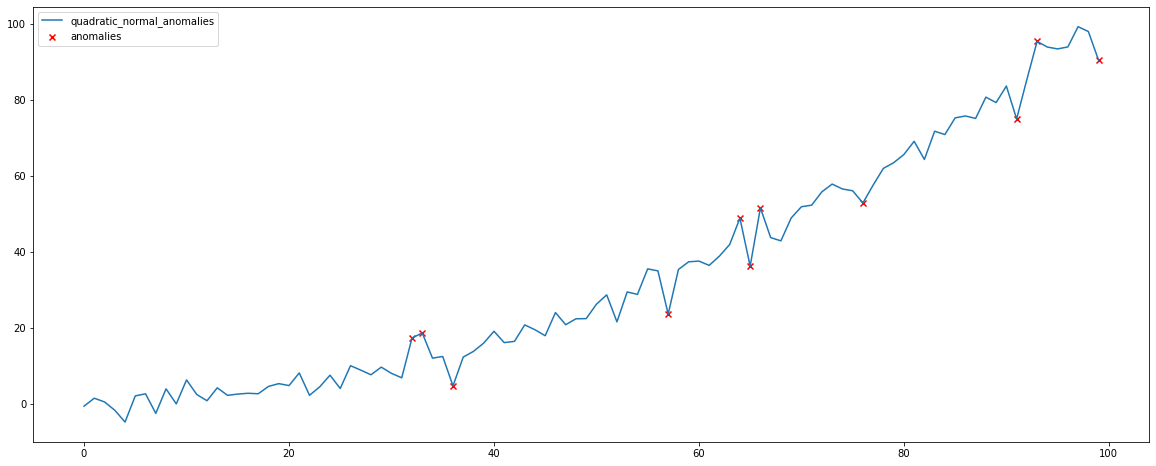

In [463]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.scatter(anomaly_index, anomaly_value, label="anomalies", marker="x", c="red")
plt.legend()
plt.show()

## Restoring values

In [464]:
data["quadratic_normal_anomalies_fix"] = fix_anomalies(data["quadratic_normal_anomalies"], anomaly_index)

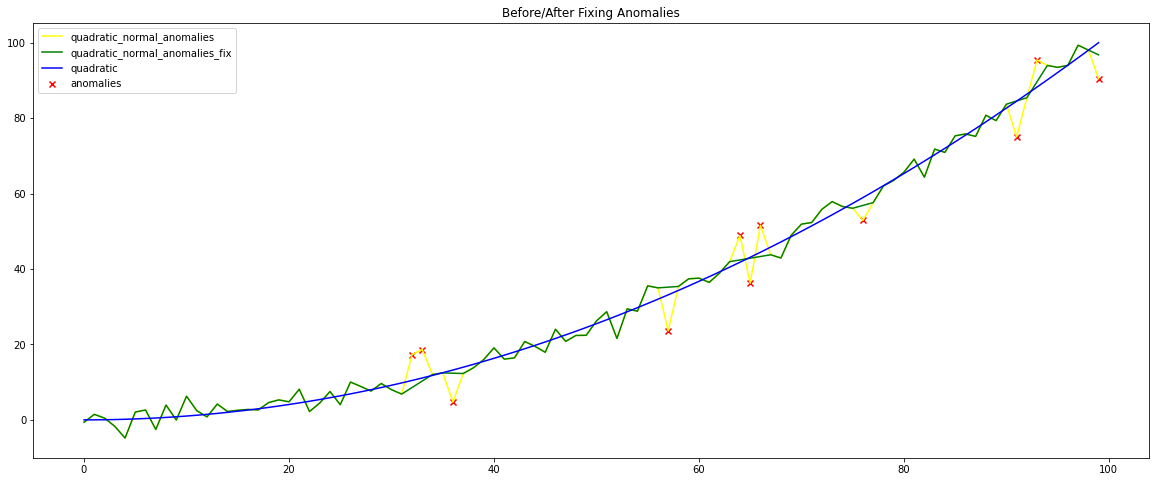

In [465]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies", c="yellow")
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.scatter(anomaly_index, anomaly_value, label="anomalies", marker="x", c="red")
plt.title("Before/After Fixing Anomalies")
plt.legend()
plt.show()

## Finding optimal polynomial power for smoothing

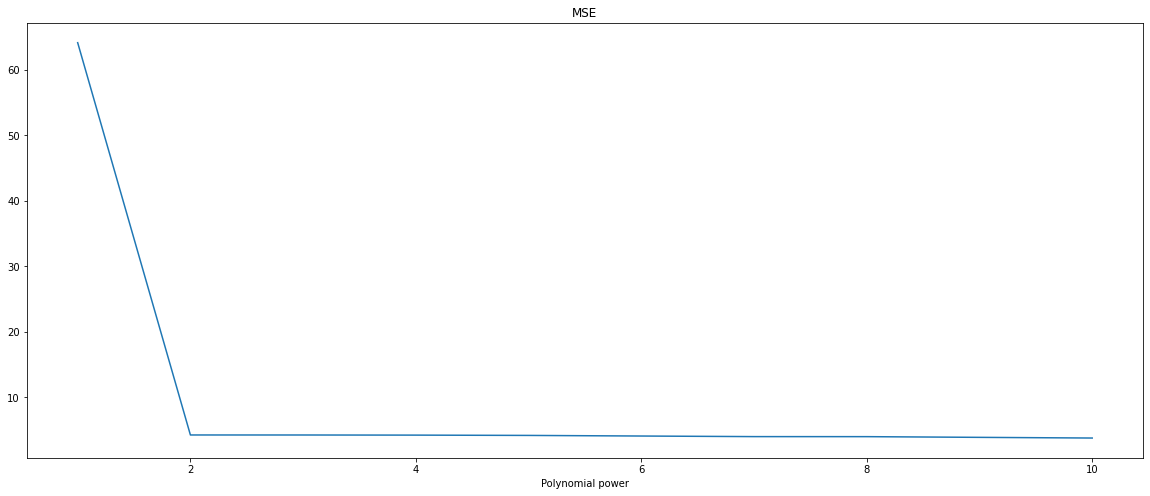

In [466]:
errs = []
pow_range = range(1, PARAM_max_test_pow)
for power in pow_range:
    errs.append((np.square(data["quadratic_normal_anomalies_fix"] - lsm(data["quadratic_normal_anomalies_fix"], power))).mean())

plt.title("MSE")
plt.xlabel("Polynomial power")
plt.plot(pow_range, errs)
plt.show()

In [467]:
PARAM_best_pow = 2

## Using LSM on Data without Anomalies

In [468]:
data["quadratic_normal_anomalies_fix_lsm"] = lsm(data["quadratic_normal_anomalies_fix"], PARAM_best_pow)

## Data Stats

In [469]:
describe_all(data, "quadratic")

,quadratic,quadratic_normal,quadratic_normal_anomalies,quadratic_normal_anomalies_fix,quadratic_normal_anomalies_fix_lsm
count,100.000,100.000,100.000,100.000,100.000
mean,0.000,0.219,0.060,0.140,0.140
std,0.000,2.000,3.315,2.083,0.134
min,0.000,-4.974,-9.527,-6.008,-0.009
25%,0.000,-1.092,-1.335,-1.124,0.019
50%,0.000,0.244,0.303,0.226,0.102
75%,0.000,1.595,1.768,1.524,0.240
max,0.000,5.263,7.545,5.263,0.450
var,0.000,4.000,10.991,4.339,0.018


## Plot

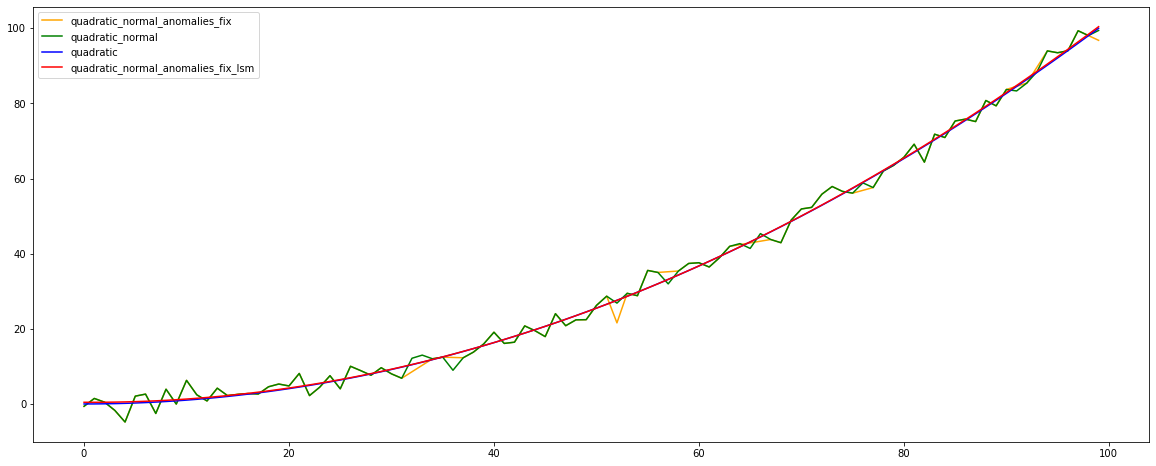

In [470]:
plt.plot(data["quadratic_normal_anomalies_fix"], label="quadratic_normal_anomalies_fix", c="orange")
plt.plot(data["quadratic_normal"], label="quadratic_normal", c="green")
plt.plot(data["quadratic"], label="quadratic", c="blue")
plt.plot(data["quadratic_normal_anomalies_fix_lsm"], label="quadratic_normal_anomalies_fix_lsm", c="red")
plt.legend()
plt.show()

## Hist

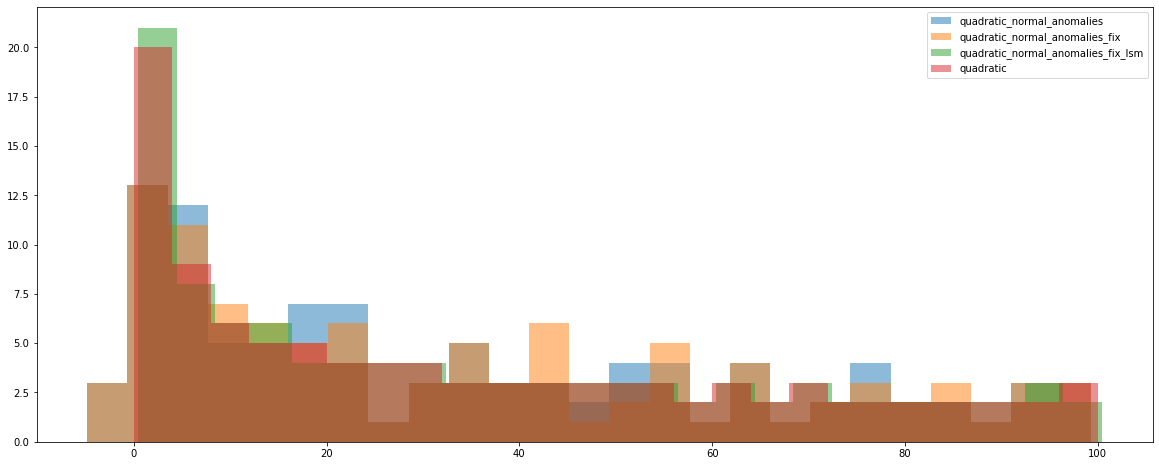

In [471]:
plt.hist(data["quadratic_normal_anomalies"], bins=25, alpha=0.5, label="quadratic_normal_anomalies")
plt.hist(data["quadratic_normal_anomalies_fix"], bins=25, alpha=0.5, label="quadratic_normal_anomalies_fix")
plt.hist(data["quadratic_normal_anomalies_fix_lsm"], bins=25, alpha=0.5, label="quadratic_normal_anomalies_fix_lsm")
plt.hist(data["quadratic"], bins=25, alpha=0.5, label="quadratic")
plt.legend()
plt.show()